[<img src="https://user-images.githubusercontent.com/79705081/109483674-d3eea600-7a7f-11eb-9a25-58c50da4cde9.png">](http://edenlibrary.ai/)

## Instructions
To run any of Eden's notebooks, please check the guides on our [Wiki page](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki).<br>
There you will find instructions on how to deploy the notebooks on [your local system](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-Locally), on [Google Colab](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-GColab), or on [MyBinder](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-MyBinder), as well as other useful links, troubleshooting tips, and more.

**Note:** If you find any issues while executing the notebook, don't hesitate to open an issue on Github. We will try to reply as soon as possible.

## Background

Supervised Contrastive Learning (Prannay Khosla et al.) is a training methodology that could outperform supervised training with cross-entropy on classification tasks. Practically, training an image classification model with Supervised Contrastive Learning is performed in two phases:
1. Training an encoder to learn to produce vector representations of input images such that representations of images in the same class will be more similar compared to representations of images in different classes.
2. Training a classifier on top of the frozen encoder.

In this notebook, this technique is implemented. We have used this tutorial as a source: https://keras.io/examples/vision/supervised-contrastive-learning/



#### Library Imports

In [1]:
!pip install tensorflow-addons

In [48]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import cv2
import os
import csv
import gc
import random
import matplotlib.pyplot as plt

from tqdm import tqdm
from glob import glob
from pathlib import Path

import tensorflow as tf 
import tensorflow_addons as tfa
from tensorflow import keras
from keras import layers
from tensorflow import keras
from keras import applications
from keras import layers
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau 
import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split

#### Auxiliar functions
Check the docstrings for more information.

In [37]:
# Function for plotting images.
def plot_samples(dataset):
    sample_images, sample_labels = next(iter(dataset))
  
    plt.figure(figsize=(8, 8))
    for ix, sample_image in enumerate(sample_images[:9]):
        plt.subplot(3, 3, ix+1)
        plt.imshow(sample_image.numpy().astype(np.uint8))
        plt.axis("off")
    
    plt.show()

def read_data(path_list, im_size=(224,224)):
    """
    Given the list of paths where the images are stored <path_list>,
    and the size for image decimation <im_size>, it returns 2 Numpy Arrays
    with the images and labels; and a dictionary with the mapping between
    classes and folders. This will be used later for displaying the predicted
    labels.

        Parameters:
            path_list (List[String]): The list of paths to the images.
            im_size (Tuple): The height and width values.

        Returns:
            X (ndarray): Images
            y (ndarray): Labels
            tag2idx (dict): Map between labels and folders.
    """

    X = []
    y = []
    
    # Exctract the file-names of the datasets we read and create a label dictionary. 
    tag2idx = {tag.split(os.path.sep)[-2]:i for i, tag in enumerate(path_list)}
    print(tag2idx)
    for path in path_list:
        for im_file in tqdm(glob(path + '*/*')): # Read all files in path
            try:
                # os.path.separator is OS agnostic (either '/' or '\'),[-2] to grab folder name.
                label = im_file.split(os.path.sep)[-3] 
                im = cv2.imread(im_file, cv2.IMREAD_COLOR) 
                # By default OpenCV read with BGR format, return back to RGB.
                im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
                # Resize to appropriate dimensions.You can try different interpolation methods.
                #im = quantize_image(im)
                im = cv2.resize(im, im_size,interpolation=cv2.INTER_AREA)
                X.append(im)
                y.append(tag2idx[label])# Append the label name to y 
            except Exception as e:
                # In case annotations or metadata are found
                print("Not a picture")
    
    X = np.array(X) # Convert list to numpy array.
    y = np.array(y).astype(np.uint8)
    
    return X, y

# Callbacks are used for saving the best weights and
# early stopping.
def get_callbacks(patience):
    """
    Callbacks are used for saving the best weights and early stopping.
    Given some configuration parameters, it creates the callbacks that
    will be used by Keras after each epoch.

        Parameters:
            weights_file (String): File name for saving the best model weights.
            patience (Integer): Number of epochs without improvement to wait.

        Returns:
            callbacks (List[Callbacks]): Configured callbacks ready to use.
    """
    return [    
        # If val_loss doesn't improve for a number of epochs set with 'patience' var 
        # training will stop to avoid overfitting.     
        EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience = patience,
                      restore_best_weights=True,
                      verbose=1),
        ModelCheckpoint(filepath='best-weights.h5', 
                     verbose=1, monitor='val_loss', 
                     save_weights_only=True, 
                     save_best_only=True
                 )   
        ]

In [38]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.02),
    layers.RandomWidth(0.1),
    layers.RandomHeight(0.1),
])

def create_encoder():
    mobilenet = keras.applications.MobileNetV3Small(
        include_top=False,
        input_shape=INPUT_SHAPE,
        weights="imagenet",
        pooling="avg"
    )

    inputs = layers.Input(shape=INPUT_SHAPE)
    augmented = data_augmentation(inputs)
    features = layers.Lambda(keras.applications.mobilenet_v3.preprocess_input)(augmented)
    outputs = mobilenet(features)

    model = keras.Model(inputs, outputs, name="encoder")
    
    return model

def create_classifier(encoder, trainable=True):
    for layer in encoder.layers:
        layer.trainable = trainable
    
    inputs = layers.Input(shape=INPUT_SHAPE)
    features = encoder(inputs)
    features = layers.Dense(HIDDEN_UNITS, activation="relu")(features)
    features = layers.Dropout(DROPOUT_RATE)(features)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(features)

    model = keras.Model(inputs, outputs, name="classifier")

    model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(),
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        metrics=['accuracy']
    )

    return model


class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super(SupervisedContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature
    
    def __call__(self, labels, feature_vectors, sample_weight):
        normalized_feature_vectors = tf.math.l2_normalize(feature_vectors, axis=1)
        logits = tf.divide(
            tf.matmul(normalized_feature_vectors, tf.transpose(normalized_feature_vectors)),
            self.temperature
        )

        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)

def add_projection_head(encoder):
    inputs = keras.Input(shape=INPUT_SHAPE)
    features = encoder(inputs)
    outputs = layers.Dense(PROJECTION_UNITS, activation="relu")(features)
    model = keras.Model(
        inputs, outputs, name="encoder-with-projection"
    )
    return model

#### Experimental Constants

In [53]:
PRETRAINING_EPOCHS = 50
HIDDEN_UNITS = 64
PROJECTION_UNITS = 128
DROPOUT_RATE = 0.25
TEMPERATURE = 0.05
INPUT_SHAPE = (224, 224, 3)
IM_SIZE = (224, 224)
NUM_EPOCHS = 20
BATCH_SIZE = 32
TEST_SPLIT = 0.2
VAL_SPLIT = 0.2
RANDOM_STATE = 2022
#WEIGHTS_FILE = "weights.h5"# File that stores updated weights
LEARNING_RATE = 1e-3
BASE_PATH = "eden_library_datasets" + os.path.sep
AUTO = tf.data.AUTOTUNE
# Datasets' paths we want to work on.
PATH_LIST = [
    BASE_PATH + "Cucumber-Cucumis_sativus-Healthy-PRX-RGB-NA-20210607/images",
    BASE_PATH + "Watermelon-Citrullus_lanatus-Healthy-PRX-RGB-NA-20210410/images",
    BASE_PATH + "Tomato-Solanum_lycopersicum-Healthy-PRX-RGB-NA-20210607/images",
    BASE_PATH + "Processing_tomato-Lycopersicum_esculentum-Healthy-PRX-RGB-NA-20200731/images",
]

tf.random.set_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

#### Loading images and Data Loaders

In [42]:
i=0
for path in PATH_LIST:
    #Define paths in an OS agnostic way.
    PATH_LIST[i] = str(Path(Path.cwd()).parents[0].joinpath(path)) 
    i+=1
x, y = read_data(PATH_LIST, IM_SIZE)

{'Cucumber-Cucumis_sativus-Healthy-PRX-RGB-NA-20210607': 0, 'Watermelon-Citrullus_lanatus-Healthy-PRX-RGB-NA-20210410': 1, 'Tomato-Solanum_lycopersicum-Healthy-PRX-RGB-NA-20210607': 2, 'Processing_tomato-Lycopersicum_esculentum-Healthy-PRX-RGB-NA-20200731': 3}


100%|███████████████████████████████████████████████████████████████████████████████████| 422/422 [01:16<00:00,  5.51it/s]


In [43]:
NUM_CLASSES = len(np.unique(y))

In [44]:
NUM_CLASSES

4

#### Creating the Datasets and Splitting the data

In [49]:
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=TEST_SPLIT,
                                                    shuffle = True,
                                                    stratify = y,
                                                    random_state = RANDOM_STATE)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                  test_size=VAL_SPLIT, 
                                                  shuffle = True,
                                                  stratify = y_train,
                                                  random_state = RANDOM_STATE)

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_ds = (
    train_ds.shuffle(BATCH_SIZE, seed=RANDOM_STATE)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

val_ds = (
    val_ds.batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_ds = (
    test_ds.batch(BATCH_SIZE)
    .prefetch(AUTO)
)

#### Displaying some samples

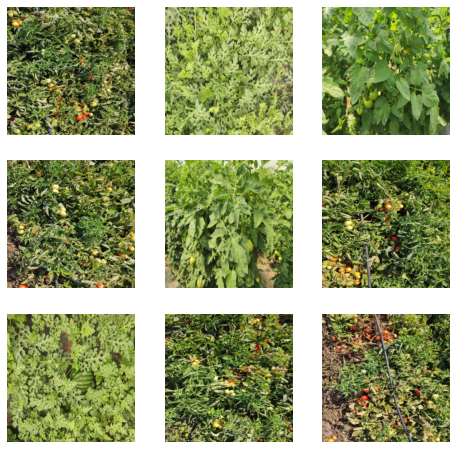

In [50]:
plot_samples(train_ds)

### Experiment 1: Training the Classifier without the pre-trained encoder

In [54]:
encoder = create_encoder()
classifier = create_classifier(encoder)

In [55]:
classifier.fit(
    train_ds,
    validation_data=val_ds,
    epochs=NUM_EPOCHS,
    callbacks = get_callbacks(patience=NUM_EPOCHS//2)
)

Epoch 1/20
18/18 [==============================] - ETA: 0s - loss: 0.2771 - accuracy: 0.9062
Epoch 1: val_loss improved from inf to 0.72599, saving model to best-weights.h5
18/18 [==============================] - 6s 107ms/step - loss: 0.2771 - accuracy: 0.9062 - val_loss: 0.7260 - val_accuracy: 0.7708
Epoch 2/20
18/18 [==============================] - ETA: 0s - loss: 0.0285 - accuracy: 0.9878
Epoch 2: val_loss did not improve from 0.72599
18/18 [==============================] - 1s 59ms/step - loss: 0.0285 - accuracy: 0.9878 - val_loss: 0.9224 - val_accuracy: 0.7431
Epoch 3/20
17/18 [===========================>..] - ETA: 0s - loss: 0.0402 - accuracy: 0.9908
Epoch 3: val_loss did not improve from 0.72599
18/18 [==============================] - 1s 55ms/step - loss: 0.0380 - accuracy: 0.9913 - val_loss: 1.2759 - val_accuracy: 0.7569
Epoch 4/20
17/18 [===========================>..] - ETA: 0s - loss: 0.0024 - accuracy: 1.0000
Epoch 4: val_loss did not improve from 0.72599
18/18 [=====

In [56]:
classifier.load_weights('best-weights.h5')
print()
print("*"*50)
accuracy = classifier.evaluate(test_ds, verbose=0)[1]
print(round(accuracy, 2))
print("*"*50)
print()


**************************************************
0.97
**************************************************



### Experiment 2: Training the Classifier with the pre-trained encoder

#### Pre-training the Enconder with the supervised-contrastive learning approach

In [57]:
encoder_pretrained = create_encoder()
encoder_with_projection_head = add_projection_head(encoder_pretrained)
encoder_with_projection_head.compile(
    loss=SupervisedContrastiveLoss(temperature=TEMPERATURE),
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE)
)

encoder_with_projection_head.fit(train_ds, 
                                 epochs=PRETRAINING_EPOCHS)

Epoch 1/50
18/18 [==============================] - 5s 50ms/step - loss: 2.6139
Epoch 2/50
18/18 [==============================] - 1s 49ms/step - loss: 2.2725
Epoch 3/50
18/18 [==============================] - 1s 50ms/step - loss: 2.2763
Epoch 4/50
18/18 [==============================] - 1s 52ms/step - loss: 2.2764
Epoch 5/50
18/18 [==============================] - 1s 53ms/step - loss: 2.2672
Epoch 6/50
18/18 [==============================] - 1s 49ms/step - loss: 2.2646
Epoch 7/50
18/18 [==============================] - 1s 46ms/step - loss: 2.2528
Epoch 8/50
18/18 [==============================] - 1s 54ms/step - loss: 2.2516
Epoch 9/50
18/18 [==============================] - 1s 45ms/step - loss: 2.2695
Epoch 10/50
18/18 [==============================] - 1s 44ms/step - loss: 2.2594
Epoch 11/50
18/18 [==============================] - 1s 47ms/step - loss: 2.2662
Epoch 12/50
18/18 [==============================] - 1s 49ms/step - loss: 2.2647
Epoch 13/50
18/18 [==================

In [58]:
classifier_pretrained = create_classifier(encoder_pretrained, trainable=False)

In [59]:
classifier_pretrained.fit(
    train_ds,
    validation_data=val_ds,
    epochs=NUM_EPOCHS,
    callbacks = get_callbacks(patience=NUM_EPOCHS//2)
)

Epoch 1/20
18/18 [==============================] - ETA: 0s - loss: 1.1587 - accuracy: 0.8368
Epoch 1: val_loss improved from inf to 0.20861, saving model to best-weights.h5
18/18 [==============================] - 4s 70ms/step - loss: 1.1587 - accuracy: 0.8368 - val_loss: 0.2086 - val_accuracy: 0.9444
Epoch 2/20
17/18 [===========================>..] - ETA: 0s - loss: 0.0196 - accuracy: 0.9982
Epoch 2: val_loss improved from 0.20861 to 0.12942, saving model to best-weights.h5
18/18 [==============================] - 1s 32ms/step - loss: 0.0187 - accuracy: 0.9983 - val_loss: 0.1294 - val_accuracy: 0.9861
Epoch 3/20
16/18 [=========================>....] - ETA: 0s - loss: 0.0149 - accuracy: 0.9980
Epoch 3: val_loss improved from 0.12942 to 0.08812, saving model to best-weights.h5
18/18 [==============================] - 1s 29ms/step - loss: 0.0135 - accuracy: 0.9983 - val_loss: 0.0881 - val_accuracy: 0.9861
Epoch 4/20
15/18 [========================>.....] - ETA: 0s - loss: 0.0134 - acc

In [60]:
classifier_pretrained.load_weights('best-weights.h5')
print()
print("*"*50)
accuracy = classifier_pretrained.evaluate(test_ds, verbose=0)[1]
print(round(accuracy, 2))
print("*"*50)
print()


**************************************************
1.0
**************************************************



## Conclusions

## Possible Extensions
1. Use a different architecture in both Teacher and Student.
2. Try a different training approach where pre-trained weights are loaded.
3. Try different epochs, batch sizes and learning rates.

## Bibliography

[1] Bucila, C., Caruana, R., & Niculescu-Mizil, A. (2006). Model compression. Knowledge Discovery and Data Mining.

[2] Hinton, G.E., Vinyals, O., & Dean, J. (2015). Distilling the Knowledge in a Neural Network. ArXiv, abs/1503.02531.
